In [36]:
import pandas as pd
import json
from pathlib import Path
import pyomo.environ as pyo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

In [3]:
file_path = Path("/Users/margheritatonon/Optimization 1/Data_Project_1.json")
with Path.open(file_path) as f:
    data = json.load(f)

#### Creating the Model

In [4]:
model = pyo.ConcreteModel()

#### Initialize the Sets

In [5]:
#the number of nurses
model.N = pyo.Set(initialize=["N1", "N2", "N3", "N4", "N5", "N6", "N7", "N8", "N9", "N10", "N11", "N12",
                              "N13", "N14", "N15", "N16", "N17", "N18", "N19", "N20", "N21", "N22", "N23",
                              "N24", "N25", "N26", "N27", "N28", "N29", "N30", "N31", "N32", "N33", "N34", "N35", "N36"])
#the number of days
model.D = pyo.Set(initialize = ["D1", "D2", "D3", "D4", "D5", "D6", "D7"])

#the number of shifts
model.S = pyo.Set(initialize = ["S1", "S2", "S3"])

#### Initialize the Data

In [6]:
model.nurse_id = pyo.Param(model.N, initialize={"N1":1, "N2":2, "N3":3, "N4":4, "N5":5, "N6":6, "N7":7, "N8":8, "N9":9, "N10":10, "N11":11, 
                                                "N12":12, "N13":13, "N14":14, "N15":15, "N16":16, "N17":17, "N18":18,"N19":19, "N20":20, 
                                                "N21":21, "N22":22, "N23":23, "N24":24, "N25":25, "N26":26, "N27":27, "N28":28, 
                                                "N29":29, "N30":30, "N31":31, "N32":32, "N33":33, "N34":34, "N35":35, "N36":36})

In [7]:
model.days = pyo.Param(model.D, initialize = {"D1":1, "D2":2, "D3":3, "D4":4, "D5":5, "D6":6, "D7":7})

In [8]:
model.shift_names = pyo.Param(model.S, initialize = {"S1":1, "S2":2, "S3":3})

Now, initializing the availability data.

In [9]:
availabilitydata = pd.DataFrame(eval(data["availability"])) #creating a dataframe from the availability data
availabilitydata["nurseid"] = availabilitydata.index

#melting the data to a desirable format so it is easier to work with
meltedavailability = pd.melt(availabilitydata, id_vars = "nurseid", var_name="day")
#converting the variables to the same name as we have initialized them as
meltedavailability["n+nurseid"] = "N" + meltedavailability["nurseid"].astype(str)
meltedavailability["d+day"] = "D" + meltedavailability["day"].astype(str) 
meltedavailability

,nurseid,day,value,n+nurseid,d+day
0,1,1,0,N1,D1
1,2,1,1,N2,D1
2,3,1,1,N3,D1
3,4,1,1,N4,D1
4,5,1,1,N5,D1
...,...,...,...,...,...
247,32,7,1,N32,D7
248,33,7,0,N33,D7
249,34,7,1,N34,D7
250,35,7,0,N35,D7


In [10]:
#creating a dictionary from the dataframe
availability_dict = {(f'{row["n+nurseid"]}', f'{row["d+day"]}'): row['value'] for _, row in meltedavailability.iterrows()}
availability_dict

{('N1', 'D1'): 0,
 ('N2', 'D1'): 1,
 ('N3', 'D1'): 1,
 ('N4', 'D1'): 1,
 ('N5', 'D1'): 1,
 ('N6', 'D1'): 1,
 ('N7', 'D1'): 1,
 ('N8', 'D1'): 1,
 ('N9', 'D1'): 1,
 ('N10', 'D1'): 1,
 ('N11', 'D1'): 0,
 ('N12', 'D1'): 1,
 ('N13', 'D1'): 0,
 ('N14', 'D1'): 0,
 ('N15', 'D1'): 1,
 ('N16', 'D1'): 1,
 ('N17', 'D1'): 1,
 ('N18', 'D1'): 1,
 ('N19', 'D1'): 0,
 ('N20', 'D1'): 1,
 ('N21', 'D1'): 1,
 ('N22', 'D1'): 1,
 ('N23', 'D1'): 1,
 ('N24', 'D1'): 1,
 ('N25', 'D1'): 1,
 ('N26', 'D1'): 1,
 ('N27', 'D1'): 0,
 ('N28', 'D1'): 1,
 ('N29', 'D1'): 1,
 ('N30', 'D1'): 0,
 ('N31', 'D1'): 1,
 ('N32', 'D1'): 1,
 ('N33', 'D1'): 1,
 ('N34', 'D1'): 1,
 ('N35', 'D1'): 1,
 ('N36', 'D1'): 0,
 ('N1', 'D2'): 1,
 ('N2', 'D2'): 1,
 ('N3', 'D2'): 1,
 ('N4', 'D2'): 1,
 ('N5', 'D2'): 0,
 ('N6', 'D2'): 0,
 ('N7', 'D2'): 1,
 ('N8', 'D2'): 1,
 ('N9', 'D2'): 1,
 ('N10', 'D2'): 1,
 ('N11', 'D2'): 0,
 ('N12', 'D2'): 1,
 ('N13', 'D2'): 1,
 ('N14', 'D2'): 1,
 ('N15', 'D2'): 1,
 ('N16', 'D2'): 1,
 ('N17', 'D2'): 0,
 ('N18', 'D

In [11]:
model.availability = pyo.Param(model.N, model.D, initialize = (availability_dict))

Now, initializing the preferences.

The difference with this is that here, every single nurse has a different preference for every day and every shift. Therefore, we made 36 different dataframes, one for each nurse.

In [12]:
#initializing a list that will hold the dataframes for every single nurse
lsmelteddata = []

x = 1 #to keep track of nurse IDs

for key, value in data["shift_preferences"].items():
    dataeachnurse = pd.DataFrame(eval(value)) #creating a dataframe for each nurse
    
    #melting each dataframe
    dataeachnurse["shift"] = dataeachnurse.index
    melt = pd.melt(dataeachnurse, id_vars = "shift", var_name="day", value_name="preference")

    lsmelteddata.append(melt)

    melt["nurseid"] = x
    x = x + 1 #updating the nurse id


lsmelteddata[0]

,shift,day,preference,nurseid
0,1,1,0.411699,1
1,2,1,0.279957,1
2,3,1,0.308344,1
3,1,2,0.475872,1
4,2,2,0.382205,1
5,3,2,0.141923,1
6,1,3,0.007664,1
7,2,3,0.433776,1
8,3,3,0.558560,1
9,1,4,0.494120,1


In [13]:
#concatenating all of the dataframes
allnursepreferences = pd.concat(lsmelteddata[i] for i in range(0, 36))

#now we need to add S, D, and N in front of each to ensure correct indexing, like the model expects
allnursepreferences["s+shift"] = "S" + allnursepreferences["shift"].astype(str)
allnursepreferences["n+nurseid"] = "N" + allnursepreferences["nurseid"].astype(str)
allnursepreferences["d+day"] = "D" + allnursepreferences["day"].astype(str)
allnursepreferences

,shift,day,preference,nurseid,s+shift,n+nurseid,d+day
0,1,1,0.411699,1,S1,N1,D1
1,2,1,0.279957,1,S2,N1,D1
2,3,1,0.308344,1,S3,N1,D1
3,1,2,0.475872,1,S1,N1,D2
4,2,2,0.382205,1,S2,N1,D2
...,...,...,...,...,...,...,...
16,2,6,0.026137,36,S2,N36,D6
17,3,6,0.915443,36,S3,N36,D6
18,1,7,0.330422,36,S1,N36,D7
19,2,7,0.068643,36,S2,N36,D7


In [14]:
#now we convert this into a dictionary with tuples of shift, day, nurseid
preference_dict = {(f'{row["n+nurseid"]}', f'{row["d+day"]}', f'{row["s+shift"]}'): row['preference'] for _, row in allnursepreferences.iterrows()}
preference_dict

{('N1', 'D1', 'S1'): 0.4116985968,
 ('N1', 'D1', 'S2'): 0.2799571603,
 ('N1', 'D1', 'S3'): 0.3083442428,
 ('N1', 'D2', 'S1'): 0.4758717424,
 ('N1', 'D2', 'S2'): 0.3822050083,
 ('N1', 'D2', 'S3'): 0.1419232494,
 ('N1', 'D3', 'S1'): 0.0076642644,
 ('N1', 'D3', 'S2'): 0.4337762138,
 ('N1', 'D3', 'S3'): 0.5585595218,
 ('N1', 'D4', 'S1'): 0.4941198302,
 ('N1', 'D4', 'S2'): 0.1169265307,
 ('N1', 'D4', 'S3'): 0.3889536391,
 ('N1', 'D5', 'S1'): 0.6302313117,
 ('N1', 'D5', 'S2'): 0.1733702359,
 ('N1', 'D5', 'S3'): 0.1963984524,
 ('N1', 'D6', 'S1'): 0.214227535,
 ('N1', 'D6', 'S2'): 0.2874754029,
 ('N1', 'D6', 'S3'): 0.4982970621,
 ('N1', 'D7', 'S1'): 0.2758508533,
 ('N1', 'D7', 'S2'): 0.4164025291,
 ('N1', 'D7', 'S3'): 0.3077466176,
 ('N2', 'D1', 'S1'): 0.4189419132,
 ('N2', 'D1', 'S2'): 0.2707546649,
 ('N2', 'D1', 'S3'): 0.3103034219,
 ('N2', 'D2', 'S1'): 0.7112844994,
 ('N2', 'D2', 'S2'): 0.1624679738,
 ('N2', 'D2', 'S3'): 0.1262475267,
 ('N2', 'D3', 'S1'): 0.1699786132,
 ('N2', 'D3', 'S2'): 

In [15]:
model.preference = pyo.Param(model.N, model.D, model.S, initialize = (preference_dict))

Now, we initialize the demand dataframe.

In [17]:
demanddf = pd.DataFrame(eval(data["demand"]))
demanddf["shift"] = demanddf.index

melteddemand = pd.melt(demanddf, id_vars="shift", var_name="day", value_name="demand")
melteddemand["s+shift"] = "S" + melteddemand["shift"].astype(str)
melteddemand["d+day"] = "D" + melteddemand["day"].astype(str)
melteddemand

,shift,day,demand,s+shift,d+day
0,1,1,8,S1,D1
1,2,1,8,S2,D1
2,3,1,8,S3,D1
3,1,2,8,S1,D2
4,2,2,8,S2,D2
5,3,2,8,S3,D2
6,1,3,8,S1,D3
7,2,3,8,S2,D3
8,3,3,8,S3,D3
9,1,4,8,S1,D4


In [18]:
#creating the dictionary
demand_dict = {(f'{row["d+day"]}', f'{row["s+shift"]}'): row['demand'] for _, row in melteddemand.iterrows()}
demand_dict

{('D1', 'S1'): 8,
 ('D1', 'S2'): 8,
 ('D1', 'S3'): 8,
 ('D2', 'S1'): 8,
 ('D2', 'S2'): 8,
 ('D2', 'S3'): 8,
 ('D3', 'S1'): 8,
 ('D3', 'S2'): 8,
 ('D3', 'S3'): 8,
 ('D4', 'S1'): 8,
 ('D4', 'S2'): 8,
 ('D4', 'S3'): 8,
 ('D5', 'S1'): 8,
 ('D5', 'S2'): 8,
 ('D5', 'S3'): 8,
 ('D6', 'S1'): 6,
 ('D6', 'S2'): 6,
 ('D6', 'S3'): 5,
 ('D7', 'S1'): 6,
 ('D7', 'S2'): 6,
 ('D7', 'S3'): 5}

In [19]:
model.demand = pyo.Param(model.D, model.S, initialize = (demand_dict))

### Initialize the Variables

In [20]:
model.x = pyo.Var(model.N, model.D, model.S, domain = pyo.Binary)

### Objective Function

In [21]:
def preference(model):
    return (sum(model.x[i, j, k] * model.preference[i, j, k] for i in model.N for j in model.D for k in model.S))

model.preference_max = pyo.Objective(rule = preference, sense = pyo.maximize)

### The constraints

Each nurse can work maximum 40 hours per week.

We know that each shift is 8 hours long. We multiply the total number of shifts by 8 for each nurse and sum, making sure it is less than 40 (the max hours).

In [22]:
def max_working_hours(model, i):
    return 8*sum(model.x[i, j, k] for j in model.D for k in model.S) <= data["max_hours"]

model.max_working_hours_constraint = pyo.Constraint(model.N, rule = max_working_hours)

The demand constraint: nurses needed on different days of the week for each shift.

In [23]:
def num_nurses_needed(model, j, k):
    return sum(model.x[i, j, k] for i in model.N) >= model.demand[j, k]

model.nurse_demand = pyo.Constraint(model.D, model.S, rule=num_nurses_needed)

No nurse can work more than 3 days in a row without a day off.

In [24]:
def max_working_days(model, i, j_1):
    return sum(model.x[i, f"D{j}", k] for j in range(j_1, j_1+3) for k in model.S) <= 3

model.max_working_days_constraint = pyo.Constraint(model.N, range(1, 5), rule=max_working_days)

No nurse can work the full weekend

In [25]:
def no_work_full_weekend(model, i):
    return sum(model.x[i, f"D{6}", k] + model.x[i, f"D{7}", k] for k in model.S) <= 1

model.no_work_full_weekend = pyo.Constraint(model.N, rule=no_work_full_weekend)

The maximum number of daily shifts is 1.

In [26]:
def max_daily_shift(model, i, j):
    return sum(model.x[i, j, k] for k in model.S) <= 1

model.max_daily_shift = pyo.Constraint(model.N, model.D, rule=max_daily_shift)

A nurse can only work when they are available.

In [27]:
def availability_of_nurse(model, i, j):
    return sum(model.x[i, j, k] for k in model.S) <= model.availability[i, j]

model.availability_constraint = pyo.Constraint(model.N, model.D, rule=availability_of_nurse)

### Solution

In [28]:
solver = pyo.SolverFactory("appsi_highs")

In [29]:
solver.solve(model, tee = False)

{'Problem': [{'Lower bound': 84.5603928954, 'Upper bound': 84.5603928954, 'Number of objectives': 1, 'Number of constraints': 0, 'Number of variables': 0, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Termination message': 'TerminationCondition.optimal'}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [30]:
model.display()

Model unknown

  Variables:
    x : Size=756, Index=N*D*S
        Key                 : Lower : Value : Upper : Fixed : Stale : Domain
         ('N1', 'D1', 'S1') :     0 :   0.0 :     1 : False : False : Binary
         ('N1', 'D1', 'S2') :     0 :   0.0 :     1 : False : False : Binary
         ('N1', 'D1', 'S3') :     0 :   0.0 :     1 : False : False : Binary
         ('N1', 'D2', 'S1') :     0 :   1.0 :     1 : False : False : Binary
         ('N1', 'D2', 'S2') :     0 :  -0.0 :     1 : False : False : Binary
         ('N1', 'D2', 'S3') :     0 :   0.0 :     1 : False : False : Binary
         ('N1', 'D3', 'S1') :     0 :   0.0 :     1 : False : False : Binary
         ('N1', 'D3', 'S2') :     0 :   0.0 :     1 : False : False : Binary
         ('N1', 'D3', 'S3') :     0 :   0.0 :     1 : False : False : Binary
         ('N1', 'D4', 'S1') :     0 :   1.0 :     1 : False : False : Binary
         ('N1', 'D4', 'S2') :     0 :   0.0 :     1 : False : False : Binary
         ('N1', 'D

## Creating the Gantt Chart

First, we define a dataframe that tells us exactly what nurse works on what day on what shift. the nurses that do not work are not included in the dataframe.

In [31]:
nurses = range(1, 37)
days = range(1, 8)
shifts = range(1, 4)

schedule_data = []

for n in nurses:
    for d in days:
        for s in shifts:
            if model.x[f"N{n}", f"D{d}", f"S{s}"].value == 1: #including only the nurses that work that particular shift
                schedule_data.append({'Nurse': n, 'Day': d,'Shift': s})

schedule = pd.DataFrame(schedule_data)

schedule

,Nurse,Day,Shift
0,1,2,1
1,1,4,1
2,1,5,1
3,1,6,3
4,2,1,1
...,...,...,...
154,35,5,3
155,35,6,1
156,36,2,1
157,36,5,1


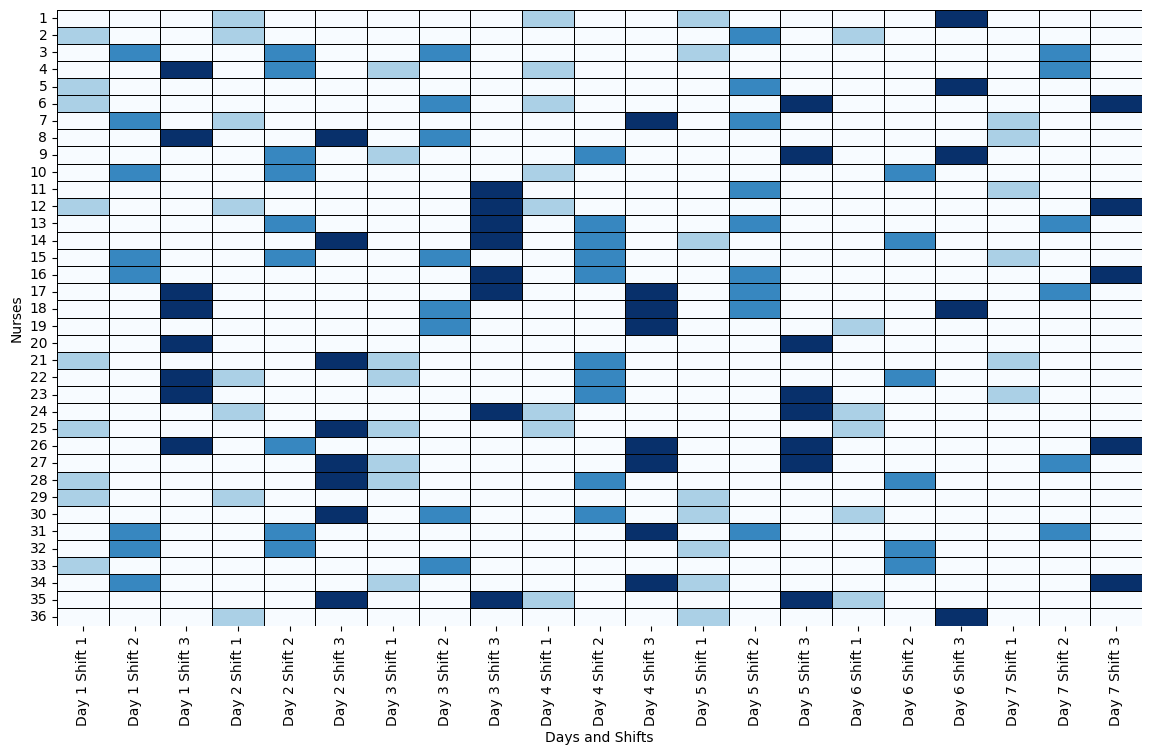

In [34]:
#creating all of the possible nurses, days, and shifts
nurses = np.arange(1, 37)
days = np.arange(1, 8)
shifts = np.arange(1, 4)

#combining the days and shifts
x_labels = pd.MultiIndex.from_product([days, shifts], names=['Day', 'Shift'])
x_ticks = ['Day {} Shift {}'.format(day, shift) for day, shift in x_labels]

#creating a zero matrix for all of the possible combinations of nurses and day/shifts
grid = np.zeros((len(nurses), len(x_labels)))

#modifying the format of the indexing in order to make it compatible with the chart we want to create
for a, row in schedule.iterrows():
    nurse_idx = row['Nurse'] -1
    day_idx = row['Day'] -1
    shift_idx = row['Shift'] -1
    x_idx = day_idx * len(shifts) + shift_idx 
    grid[nurse_idx, x_idx] = row["Shift"]  #set equal to the shift number so that we can color code based on the shift

#plotting and adding labels
plt.figure(figsize=(14, 8))
sns.heatmap(grid, cmap="Blues", cbar=False, linewidths=0.5, linecolor='black')

plt.yticks(np.arange(len(nurses)) + 0.5, nurses)
plt.xticks(np.arange(len(x_ticks)) + 0.5, x_ticks, rotation=90)

plt.xlabel('Days and Shifts')
plt.ylabel('Nurses')


plt.show()


However, this is not the final plot. We deal with making it more aesthetically pleasing next.

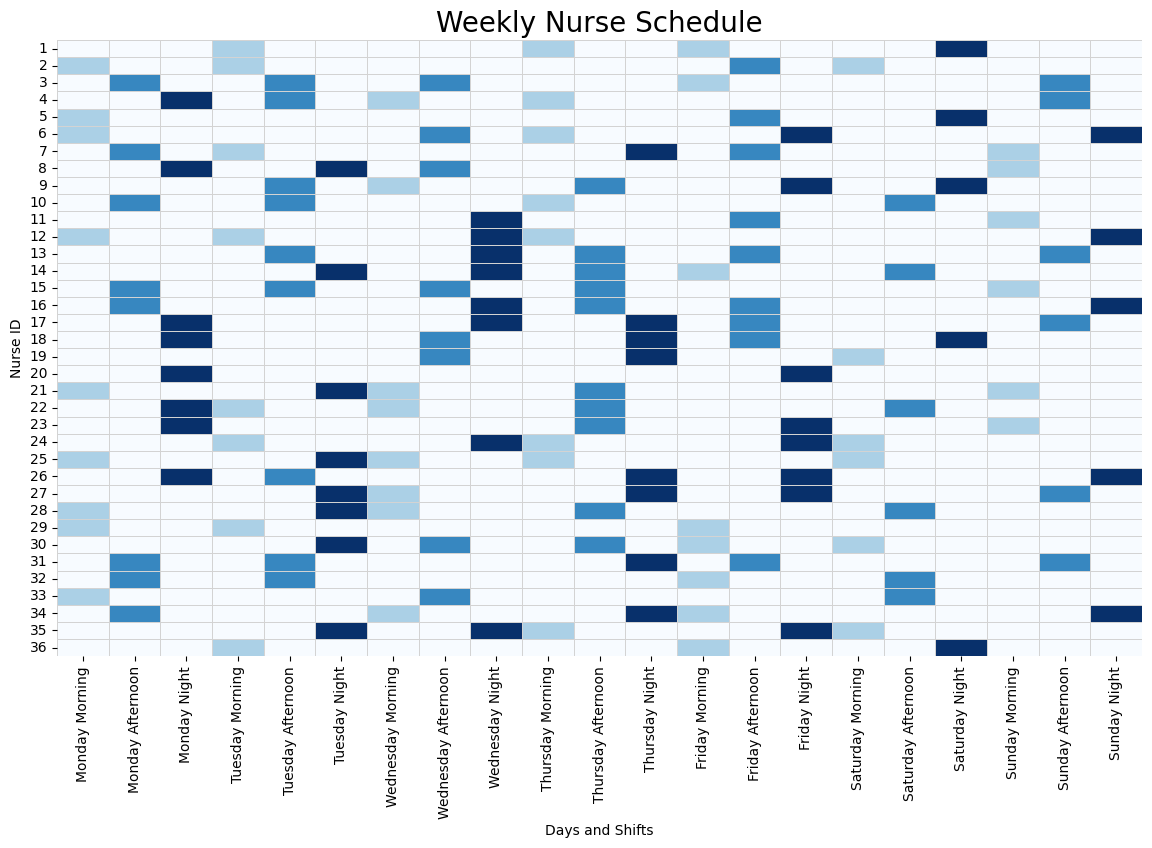

In [35]:
#changing the color scheme
plt.figure(figsize=(14, 8))
sns.heatmap(grid, cmap="Blues", cbar=False, linewidths=0.5, linecolor='lightgrey')


#changing the day # and shift # to the actual shift and day names (makes it more interpretable for the nurses)
x_ticks = ['Monday Morning', 'Monday Afternoon', 'Monday Night',  # Day 1 shifts
           'Tuesday Morning', 'Tuesday Afternoon', 'Tuesday Night',  # Day 2 shifts
           'Wednesday Morning', 'Wednesday Afternoon', 'Wednesday Night',  # Day 3 shifts
           'Thursday Morning', 'Thursday Afternoon', 'Thursday Night',  # Day 4 shifts
           'Friday Morning', 'Friday Afternoon', 'Friday Night',  # Day 5 shifts
           'Saturday Morning', 'Saturday Afternoon', 'Saturday Night',  # Day 6 shifts
           'Sunday Morning', 'Sunday Afternoon', 'Sunday Night']  # Day 7 shifts


plt.yticks(np.arange(len(nurses)) + 0.5, nurses)
plt.xticks(np.arange(len(x_ticks)) + 0.5, x_ticks, rotation=90)

plt.xlabel('Days and Shifts')
plt.ylabel('Nurse ID')
plt.title('Weekly Nurse Schedule', fontsize = 20)

plt.show()

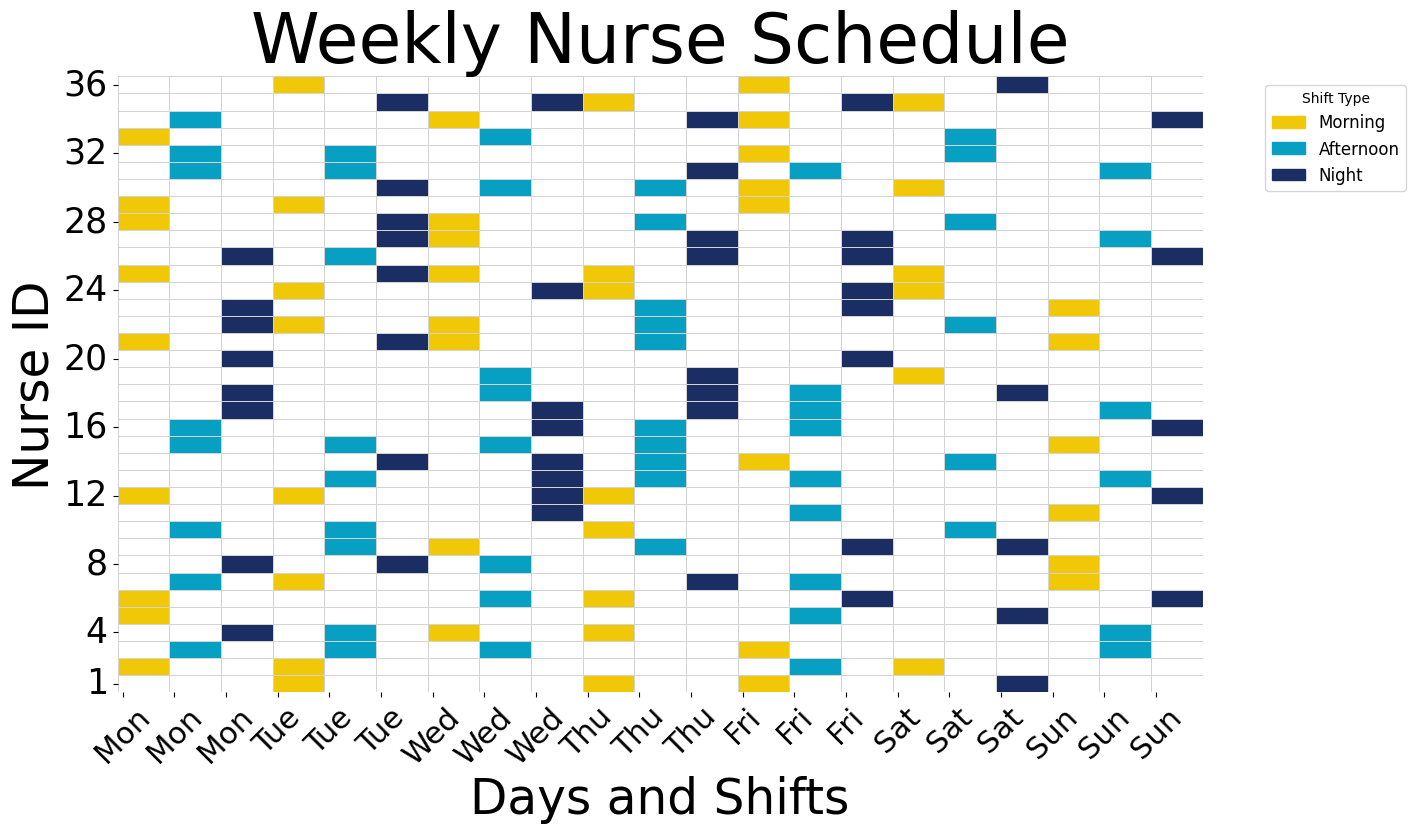

In [37]:
nurses = np.arange(1, 37)
days = np.arange(1, 8)
shifts = np.arange(1, 4)
x_labels = pd.MultiIndex.from_product([days, shifts], names=['Day', 'Shift'])
x_ticks = ['Day {} Shift {}'.format(day, shift) for day, shift in x_labels]
grid = np.zeros((len(nurses), len(x_labels)))
for a, row in schedule.iterrows():
    nurse_idx = row['Nurse'] -1
    day_idx = row['Day'] -1
    shift_idx = row['Shift'] -1
    x_idx = day_idx * len(shifts) + shift_idx 
    grid[nurse_idx, x_idx] = row["Shift"]
plt.figure(figsize=(14, 8))

#changing the colormap
colors = ["white", "#f0c808", "#07a0c3", "#1b2e63"]
cmap = ListedColormap(colors)
sns.heatmap(grid, cmap=cmap, cbar=False, linewidths=0.5, linecolor='lightgrey')


x_ticks = ['Mon', 'Mon', 'Mon',
           'Tue', 'Tue', 'Tue',
           'Wed', 'Wed', 'Wed',
           'Thu', 'Thu', 'Thu',
           'Fri', 'Fri', 'Fri',
           'Sat', 'Sat', 'Sat',
           'Sun', 'Sun', 'Sun']

nurse_labels = [1, 4, 8, 12, 16, 20, 24, 28, 32, 36]
nurse_positions = [label - 1 + 0.5 for label in nurse_labels]
plt.yticks(nurse_positions, nurse_labels, fontsize=25)


plt.xticks(np.arange(len(x_ticks))+0.1, x_ticks, rotation=45, fontsize=22)
plt.xlabel('Days and Shifts', fontsize=35)
plt.ylabel('Nurse ID', fontsize=35)
plt.title('Weekly Nurse Schedule', fontsize = 50)

legend_labels = ["Morning", "Afternoon", "Night"]
legend_colors = [Patch(color=colors[i+1], label=legend_labels[i]) for i in range(len(colors)-1)]
plt.legend(handles=legend_colors, title='Shift Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

#so nurse 36 is at the top:
plt.gca().invert_yaxis()

plt.show()
